In [17]:
from pathlib import Path
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import time

import torch
import torch.nn as nn
 
from sklearn.model_selection import train_test_split

In [2]:
PATH = Path("/content/drive/MyDrive/corona")
masks_path = PATH/"mask"
imgs_path = PATH/"image"

CREATE DATASET

In [3]:
def create_dataset(masks_path, imgs_path):

  img_list,mask_list_cropped = [], []

  for patient_src in (list(masks_path.iterdir())): #patient_source: /content/gdrive/My Drive/Covid19/Data/mask/0
    patient_num = str(patient_src).split('/')[-1]  #patient_num: 0
    try:
      for i in list(Path(masks_path/str(int(patient_num))).iterdir()): #i: /content/gdrive/My Drive/Covid19/Data/mask/0/115.png
        ct_num = str(i).split('/')[-1].split('.')[-2] #ct_num: 115
        img_list.append(np.array(Image.open(Path(str(imgs_path)+"/"+patient_num+"/"+ct_num+".jpg")).resize((256,256), Image.ANTIALIAS)))
        mask_list_cropped.append(np.array(Image.open(Path(str(masks_path)+"/"+patient_num+"/"+ct_num+".png")).resize((256,256), Image.ANTIALIAS)))
    except:
      pass

  mask_cropped_tensor = torch.tensor(mask_list_cropped,  dtype=torch.float32)
  img_tensor = torch.tensor(img_list,  dtype=torch.float32)
  
  return img_tensor, mask_cropped_tensor

In [4]:
imgs_tensor, masks_tensor = create_dataset(masks_path, imgs_path)

DISPLAY DATASET

In [5]:
def display_data(img_list,mask_list):
  for i in range(len(img_list)):
    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 1)
    imgplot = plt.imshow(np.array(img_list[i]).astype('uint8'))
    ax.set_title('Image')

    ax = fig.add_subplot(1, 2, 2)
    imgplot = plt.imshow(mask_list[i].squeeze())
    ax.set_title('Mask')

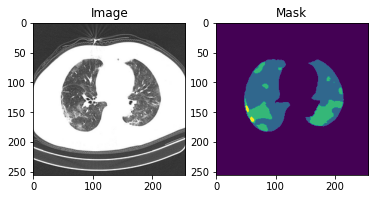

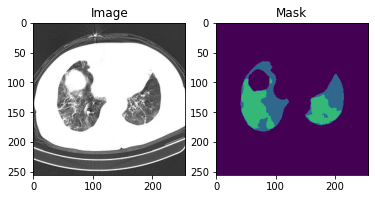

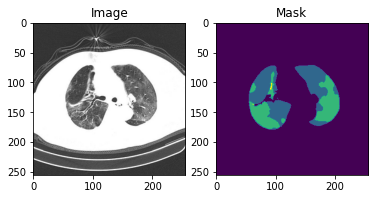

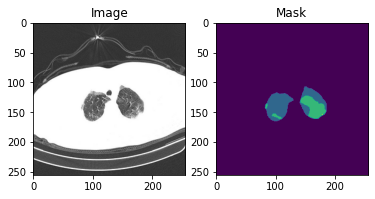

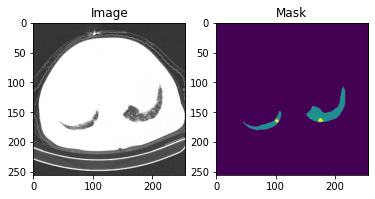

In [6]:
display_data(imgs_tensor[10:15], masks_tensor[10:15])

In [7]:
images = imgs_tensor.cuda()
masks = masks_tensor.cuda()

SPLIT DATASET - CREATE DATALOADER

In [10]:
image_tensor = images.permute(0,3,1,2)
mask_tensor = masks.unsqueeze(0).permute(1,0,2,3)
X_train, X_val, y_train, y_val = train_test_split(image_tensor, mask_tensor, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(f'Train length:{len(X_train)}\nValidation length:{len(X_val)}\nTest Length:{len(X_test)}')

Train length:480
Validation length:150
Test Length:120


In [11]:
class Dataset():
  def __init__(self, x, y): 
      self.x,self.y = x,y
  def __len__(self): 
      return len(self.x)
  def __getitem__(self, i): 
      return self.x[i],self.y[i]

class DataLoader():
  def __init__(self, ds, bs): 
      self.ds, self.bs = ds, bs
  def __iter__(self):
      n = len(self.ds)      
      for i in range(0, n, self.bs):
        yield self.ds[i:i+self.bs]

In [12]:
train_ds = Dataset(X_train, y_train)
valid_ds = Dataset(X_val, y_val)
test_ds = Dataset(X_test, y_test)

train_dl = DataLoader(train_ds, 40)
valid_dl = DataLoader(valid_ds, 40)
test_dl = DataLoader(test_ds, 40)

UNET

In [13]:
def dual_conv(in_channel, out_channel):
    conv = nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(out_channel),

        nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(out_channel),
    )
    return conv

class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        self.dwn_conv1 = dual_conv(3, 32)
        self.dwn_conv2 = dual_conv(32,64)
        self.dwn_conv3 = dual_conv(64,128)
        self.dwn_conv4 = dual_conv(128,256)
        self.dwn_conv5 = dual_conv(256,512)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.trans1 = nn.ConvTranspose2d(512,256, kernel_size=2, stride= 2)
        self.up_conv1 = dual_conv(512,256)
        self.trans2 = nn.ConvTranspose2d(256,128, kernel_size=2, stride= 2)
        self.up_conv2 = dual_conv(256,128)
        self.trans3 = nn.ConvTranspose2d(128,64, kernel_size=2, stride= 2)
        self.up_conv3 = dual_conv(128,64)
        self.trans4 = nn.ConvTranspose2d(64,32, kernel_size=2, stride= 2)
        self.up_conv4 = dual_conv(64,32)

        self.out = nn.Conv2d(32, 1, kernel_size=1)

    def forward(self, image):
        x1 = self.dwn_conv1(image)
        x2 = self.maxpool(x1)
        x3 = self.dwn_conv2(x2)
        x4 = self.maxpool(x3)
        x5 = self.dwn_conv3(x4)
        x6 = self.maxpool(x5)
        x7 = self.dwn_conv4(x6)
        x8 = self.maxpool(x7)
        x9 = self.dwn_conv5(x8)

        x = self.trans1(x9)
        x = self.up_conv1(torch.cat([x,x7], 1))

        x = self.trans2(x)
        x = self.up_conv2(torch.cat([x,x5], 1))

        x = self.trans3(x)
        x = self.up_conv3(torch.cat([x,x3], 1))

        x = self.trans4(x)
        x = self.up_conv4(torch.cat([x,x1], 1))
        
        x = self.out(x)       
        return x

TRAIN MODEL

In [16]:
def sigmoid_range(x, low, high): 
  return torch.sigmoid(x) * (high-low) + low

def loss_func(preds, targets):
  return torch.sqrt(((sigmoid_range(preds,0,4.5).squeeze() - targets) ** 2).mean())

def accuracy(preds,yb):
  return (torch.round(sigmoid_range(preds,0,4.5))==yb).float().mean()

def validation_acc(model):
  return torch.stack([accuracy(model(xb), yb) for xb, yb in valid_dl]).mean().item()

def test_acc(model):
  return torch.stack([accuracy(model(xb), yb) for xb, yb in test_dl]).mean().item()

def train_acc(model):
  return torch.stack([accuracy(model(xb), yb) for xb, yb in train_dl]).mean().item()

In [18]:
if __name__ == '__main__':
  model = Unet()
  model.cuda()
optim = torch.optim.SGD(model.parameters(), lr=1e-1)

In [20]:
def train(model, epochs=5):
  start_time = time.time()
  temp = 1e-70

  for epoch in range(epochs):
    print(f"{epoch+1}. EPOCH--------------------------------------------------")
    batch_num, epoch_loss = 0, 0
    model.train()

    for xb, yb in train_dl:
      if (batch_num == 0):
        total_batch = len(X_train)//len(xb) + 1
      batch_num += 1
      preds = model(xb)
      loss = loss_func(preds, yb)
      print("\t%d/%d train batch loss: %.6f" %(batch_num, total_batch, loss))
      epoch_loss += loss
      loss.backward()
      optim.step()
      optim.zero_grad()

    print("\t%d.EPOCH train mean loss: %.6f" %((epoch+1),(epoch_loss/batch_num)))
    print()
    
    batch_num, epoch_loss = 0, 0

    with torch.no_grad():
      trn_acc = train_acc(model)
      print("\ttrain accuracy: %.4f" %(trn_acc))

      val_acc = validation_acc(model)
      print("\tvalidation accuracy: %.4f" %(val_acc))

    if (val_acc > temp):
      torch.save(model.state_dict(), "/content/drive/MyDrive/corona/final.pt")
      print("***BEST MODEL CHANGED***")
      temp = val_acc
    print()
  print("--- in %.4f minutes ---" %((time.time() - start_time)/60))

In [21]:
train(model,epochs=10)

1. EPOCH--------------------------------------------------
	1/13 train batch loss: 2.334415
	2/13 train batch loss: 2.307129
	3/13 train batch loss: 2.134460
	4/13 train batch loss: 1.991679
	5/13 train batch loss: 1.793046
	6/13 train batch loss: 1.672615
	7/13 train batch loss: 1.536548
	8/13 train batch loss: 1.411435
	9/13 train batch loss: 1.302967
	10/13 train batch loss: 1.171906
	11/13 train batch loss: 1.065974
	12/13 train batch loss: 0.983690
	1.EPOCH train mean loss: 1.642155

	train accuracy: 0.1197
	validation accuracy: 0.1161
***BEST MODEL CHANGED***

2. EPOCH--------------------------------------------------
	1/13 train batch loss: 0.884696
	2/13 train batch loss: 0.816323
	3/13 train batch loss: 0.744531
	4/13 train batch loss: 0.695862
	5/13 train batch loss: 0.642339
	6/13 train batch loss: 0.607647
	7/13 train batch loss: 0.563563
	8/13 train batch loss: 0.538195
	9/13 train batch loss: 0.499359
	10/13 train batch loss: 0.489607
	11/13 train batch loss: 0.479143
	12

TEST MODEL

In [25]:
if __name__ == '__main__':
  model = Unet()
  model.load_state_dict(torch.load("/content/drive/MyDrive/corona/final.pt"))
  model.cuda()
  model.eval()

with torch.no_grad():
  print("test accuracy: ",test_acc(model))

test accuracy:  0.9100691676139832
